<a href="https://colab.research.google.com/github/Apaulgithub/Variants-of-Anomaly-Detector/blob/main/Autoencoder_Anomaly_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Download the dataset
dataframe = pd.read_csv('/content/drive/MyDrive/practice/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()


from sklearn.model_selection import train_test_split

# Assuming raw_data is already loaded as a NumPy array
# The last column = labels
labels = raw_data[:, -1]
data = raw_data[:, :-1]

# Split into train and test
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

# Normalize
min_val = train_data.min()
max_val = train_data.max()

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

# Convert to tensors
train_data = torch.tensor(train_data, dtype=torch.float32)
test_data = torch.tensor(test_data, dtype=torch.float32)
train_labels = torch.tensor(train_labels.astype(bool))
test_labels = torch.tensor(test_labels.astype(bool))

# Separate normal/anomalous
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]
anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]


# ---- Define Autoencoder Model ----
class AnomalyDetector(nn.Module):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(140, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 140),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AnomalyDetector().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss()

# DataLoader for batching
batch_size = 1
train_loader = DataLoader(normal_train_data, batch_size=batch_size, shuffle=True)

# ---- Training ----
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Validation loss on all test data
    model.eval()
    with torch.no_grad():
        val_outputs = model(test_data.to(device))
        val_loss = criterion(val_outputs, test_data.to(device))
        val_losses.append(val_loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch [1/50] Train Loss: 0.0117, Val Loss: 0.0102
Epoch [2/50] Train Loss: 0.0068, Val Loss: 0.0085
Epoch [3/50] Train Loss: 0.0062, Val Loss: 0.0077
Epoch [4/50] Train Loss: 0.0054, Val Loss: 0.0079
Epoch [5/50] Train Loss: 0.0049, Val Loss: 0.0066
Epoch [6/50] Train Loss: 0.0046, Val Loss: 0.0063
Epoch [7/50] Train Loss: 0.0044, Val Loss: 0.0062
Epoch [8/50] Train Loss: 0.0041, Val Loss: 0.0063
Epoch [9/50] Train Loss: 0.0039, Val Loss: 0.0057
Epoch [10/50] Train Loss: 0.0039, Val Loss: 0.0059
Epoch [11/50] Train Loss: 0.0037, Val Loss: 0.0056
Epoch [12/50] Train Loss: 0.0037, Val Loss: 0.0060
Epoch [13/50] Train Loss: 0.0036, Val Loss: 0.0054
Epoch [14/50] Train Loss: 0.0035, Val Loss: 0.0053
Epoch [15/50] Train Loss: 0.0035, Val Loss: 0.0056
Epoch [16/50] Train Loss: 0.0034, Val Loss: 0.0054
Epoch [17/50] Train Loss: 0.0033, Val Loss: 0.0056
Epoch [18/50] Train Loss: 0.0033, Val Loss: 0.0053
Epoch [19/50] Train Loss: 0.0032, Val Loss: 0.0051
Epoch [20/50] Train Loss: 0.0032, Val Lo

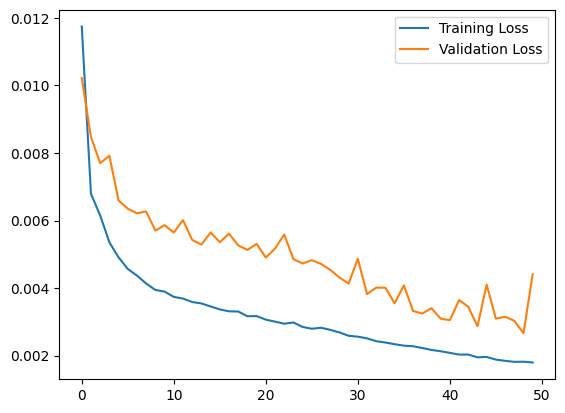

In [ ]:
# ---- Plot loss ----
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
# ---- Compute threshold ----
model.eval()
with torch.no_grad():
    reconstructions = model(normal_train_data.to(device))
    train_loss = torch.mean(torch.abs(reconstructions - normal_train_data.to(device)), dim=1)
threshold = train_loss.mean() + train_loss.std()
print("Threshold:", threshold.item())

Threshold: 0.004281763453036547


In [ ]:
# ---- Evaluate on test ----
def predict(model, data, threshold):
    with torch.no_grad():
        reconstructions = model(data.to(device))
        loss = torch.mean(torch.abs(reconstructions - data.to(device)), dim=1)
        preds = loss < threshold
    return preds.cpu()

preds = predict(model, test_data, threshold)

# ---- Compute metrics ----
preds_np = preds.numpy()
labels_np = test_labels.numpy()

print("Accuracy:", accuracy_score(labels_np, preds_np))
print("Precision:", precision_score(labels_np, preds_np))
print("Recall:", recall_score(labels_np, preds_np))

Accuracy: 0.904
Precision: 0.8741935483870967
Recall: 0.9678571428571429
